In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('stock_price_list',delimiter='\t')

def func_moving_average(stock):
    
    #setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    #creating dataframe with date and the target variable
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data[stock][i]
    #splitting into train and validation
    train = new_data[:987]
    valid = new_data[987:]
    #make predictions
    preds = []
    for i in range(0,247):
        a = train['Close'][len(train)-247+i:].sum() + sum(preds)
        b = a/248
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = preds
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    return 'rms:',rms

def func_linear_regression(stock):
    #setting index as date values
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #sorting
    data = df.sort_index(ascending=True, axis=0)

    #creating a separate dataset
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data[stock][i]
    #create features
    from fastai.structured import  add_datepart
    add_datepart(new_data, 'Date')
    new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
    new_data['mon_fri'] = 0
    for i in range(0,len(new_data)):
        if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
            new_data['mon_fri'][i] = 1
        else:
            new_data['mon_fri'][i] = 0
    #split into train and validation
    train = new_data[:987]
    valid = new_data[987:]

    x_train = train.drop('Close', axis=1)
    y_train = train['Close']
    x_valid = valid.drop('Close', axis=1)
    y_valid = valid['Close']

    #implement linear regression
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x_train,y_train)
    #make predictions and find the rmse
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = preds

    valid.index = new_data[987:].index
    train.index = new_data[:987].index

    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    return 'rms:',rms

def func_knn(stock):
    #importing libraries
    from sklearn import neighbors
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    #setting index as date values
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #sorting
    data = df.sort_index(ascending=True, axis=0)

    #creating a separate dataset
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data[stock][i]
    #create features
    from fastai.structured import  add_datepart
    add_datepart(new_data, 'Date')
    new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
    new_data['mon_fri'] = 0
    for i in range(0,len(new_data)):
        if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
            new_data['mon_fri'][i] = 1
        else:
            new_data['mon_fri'][i] = 0
    #split into train and validation
    train = new_data[:987]
    valid = new_data[987:]

    x_train = train.drop('Close', axis=1)
    y_train = train['Close']
    x_valid = valid.drop('Close', axis=1)
    y_valid = valid['Close']
    #scaling data
    x_train_scaled = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(x_valid)
    x_valid = pd.DataFrame(x_valid_scaled)

    #using gridsearch to find the best parameter
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)

    #fit the model and make predictions
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = preds
    plt.plot(valid[['Close', 'Predictions']])
    plt.plot(train['Close'])
    return 'rms:',rms

In [5]:
def best_model(stock):
    knn_rms = func_knn(stock)[1]
    linear_regression_rms = func_linear_regression(stock)[1]
    moving_average_rms = func_moving_average(stock)[1]
    list_ = [knn_rms,linear_regression_rms,moving_average_rms]
    minpos = list_.index(min(list_)) 
    if minpos == 0:
        return f'knn model is the best with rms: {knn_rms}'.format(knn_rms)
    elif minpos == 1:
        return f'linear_regression model is the best with rms: {linear_regression_rms}'.format(linear_regression_rms)
    else:
        return f'moving average model is the best with rms: {moving_average_rms}'.format(moving_average_rms)

/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15

'linear_regression model is the best with rms: 36.249188679694555'

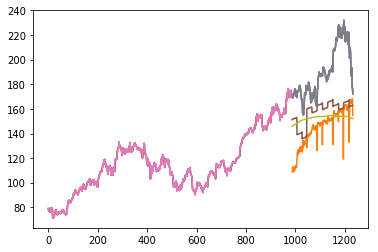

In [6]:
best_model('AAPL')